In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler 

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
t1d_mat = file_path + "T1D_new_04_09_short.bed"
t1d_mat = file_path + 't1d_final_short_after_loci_filtering.bed'
t2d_mat = file_path + "T2D_new_04_09_short.bed"
t2d_mat = file_path + 't2d_final_short_after_loci_filtering.bed'
# topmed_mat = file_path + "topmed_final.bed"

# Automating Experiments

## Data Ingestion

In [6]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

Originally 12380 variants. Filtering out 0 variants; left with 12380


In [7]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

## Label Spreading Model Tests

In [7]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data, known_labels)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]
        
        rus = RandomUnderSampler(random_state=42)
#         print("Test labels 0/1:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))
        test_data, test_labels = rus.fit_resample(test_data, test_labels)
#         print("After balance:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

        print('fitting')
        model.fit(train_data, train_labels)
        print('finished fitting')
        
        # Predict on test
        pred_labels = model.predict(test_data)

        # Measure accuracy
        acc = accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels)
        rec = recall_score(test_labels, pred_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
        total_fp_score += (fp / (fp + tp))
        total_tp_score += (tp / (fp + tp))
        total_fn_score += (fn / (fn + tn))
        total_tn_score += (tn / (fn + tn))
        num += 1

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", total_fp_score / num, total_tp_score / num, total_tn_score / num, total_fn_score / num)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, total_fp_score / num, total_tp_score / num, total_fn_score / num, total_tn_score / num

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.001]
# low_prob_thresholds = [0.000005]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
#                         norm_model = make_pipeline(MinMaxScaler(), model)
                        norm_model = model
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec, fp, tp, fn, tn]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec, fp, tp, fn, tn]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv('./Results/fixed_balanced_testing_rbf_results_no_norm.csv')

high:  0.01 low 5e-06:Positive 662; Negative 607; Unlabelled 23731; 
fitting


KeyboardInterrupt: 

In [10]:
t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, 0.0001, 0.000006))

model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
norm_model = model
model.fit(t1d_data, t1d_labels_thresh)

pickle.dump( norm_model, open( "./label_spreading_model", "wb" ) )

In [ ]:
# t1d_res = pandas.read_csv('./Results/label_spreading_res_normalized_fixed_cv.csv')
# t2d_res = pandas.read_csv('./Results/t2d_normalized_label_spreading.csv')
t1d_res = res

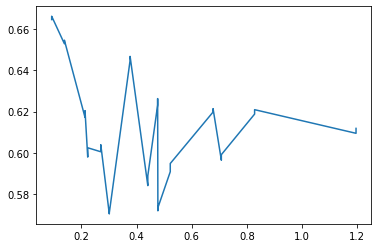

In [21]:
x = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

In [13]:
x = t2d_res["Labelled/Unlabelled Ratio"]
y = t2d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

NameError: name 't2d_res' is not defined

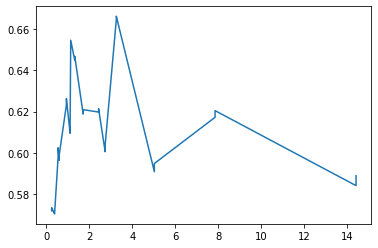

In [22]:
x = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

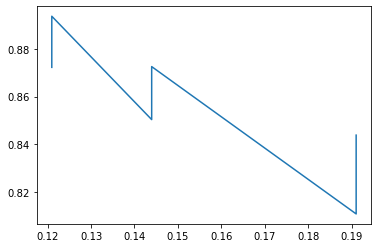

In [13]:
x = t2d_res["Pos/Neg ratio"]
y = t2d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

In [3]:
t1d_res = pandas.read_csv('./Results/balanced_testing_rbf_results.csv')

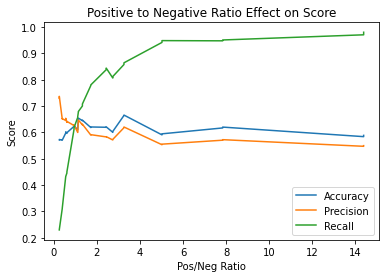

In [23]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

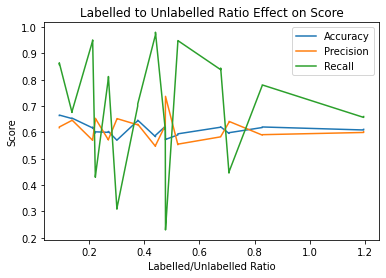

In [24]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [6]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered_tp_fp.csv')

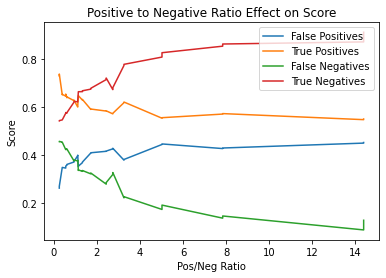

In [25]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

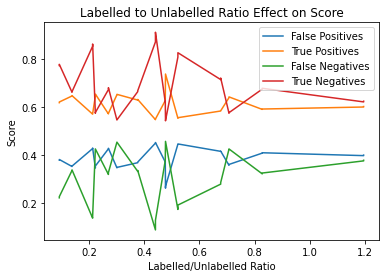

In [26]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [3]:
svc = pandas.read_csv('./Results/fixed_balanced_testing_SVC.csv')
res = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_no_norm.csv')
res_norm = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_minmax_norm.csv')
pca_20 = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_PCA_20_components_no_norm.csv')
pca_20_norm = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_PCA_20_components_normalized.csv')
bin_res = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_bin_data_no_norm.csv')

In [5]:
print('Max accuracy')
print('svc:', max(svc['Average Accuracy Score']))
print('res:', max(res['Average Accuracy Score']))
print('res_norm:', max(res_norm['Average Accuracy Score']))
print('pca_20:', max(pca_20['Average Accuracy Score']))
print('pca_20_norm:', max(pca_20_norm['Average Accuracy Score']))
print('bin_res:', max(bin_res['Average Accuracy Score']))

print('Max precision')
print('svc:', max(svc['Average Precision Score']))
print('res:', max(res['Average Precision Score']))
print('res_norm:', max(res_norm['Average Precision Score']))
print('pca_20:', max(pca_20['Average Precision Score']))
print('pca_20_norm:', max(pca_20_norm['Average Precision Score']))
print('bin_res:', max(bin_res['Average Precision Score']))

print('Max recall')
print('svc:', max(svc['Average Recall Score']))
print('res:', max(res['Average Recall Score']))
print('res_norm:', max(res_norm['Average Recall Score']))
print('pca_20:', max(pca_20['Average Recall Score']))
print('pca_20_norm:', max(pca_20_norm['Average Recall Score']))
print('bin_res:', max(bin_res['Average Recall Score']))

Max accuracy
svc: 0.6284090909090909
res: 0.6630681818181818
res_norm: 0.6661290322580646
pca_20: 0.65
pca_20_norm: 0.6363636363636364
bin_res: 0.6625
Max precision
svc: 0.85
res: 0.8205518018018019
res_norm: 0.7372173298452912
pca_20: 0.8771509086726479
pca_20_norm: 0.7621702858544964
bin_res: 0.762432615170952
Max recall
svc: 1.0
res: 0.5227272727272727
res_norm: 0.9806451612903226
pca_20: 0.5568181818181819
pca_20_norm: 0.9903225806451612
bin_res: 0.9838180856689582
